In [327]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
from datetime import timedelta

import tqdm
from enflows.distributions import StandardNormal, Uniform, DiagonalNormal, MADEMoG, MOG
from enflows.transforms import Sigmoid, ScalarScale, ScalarShift, RandomPermutation, MaskedSumOfSigmoidsTransform, ConditionalSumOfSigmoidsTransform
from enflows.transforms.normalization import ActNorm
from enflows.transforms.base import CompositeTransform, InverseTransform
from enflows.transforms.lipschitz import LipschitzDenseNetBuilder, iResBlock
from enflows.nn.nets.activations import Sin
from enflows.nn.nets import ResidualNet
from enflows.flows.base import Flow
from enflows.transforms.injective import FixedNorm, ConstrainedAnglesSigmoid, ClampedAngles

In [328]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [329]:
def set_random_seeds (seed=1234):
    np.random.seed(seed)
    torch.manual_seed(seed)

def uniform_p_norm (beta):
    return torch.ones_like(beta)

In [330]:
def spherical_to_cartesian_torch(arr):
    # meant for batches of vectors, i.e. arr.shape = (mb, n)
    
    assert arr.shape[1] >= 2
    r = arr[:, :1]
    angles = arr[:, 1:]
    
    sin_prods = torch.cumprod(torch.sin(angles), dim=1)
    x1 = r * torch.cos(angles[:, :1])
    xs = r * sin_prods[:, :-1] * torch.cos(angles[:, 1:])
    xn = r * sin_prods[:, -1:]

    return torch.cat((x1, xs, xn), dim=1)

def cartesian_to_spherical_torch(arr):
    # meant for batches of vectors, i.e. arr.shape = (mb, n)
    eps = 1e-5
    assert arr.shape[-1] >= 2
    radius = torch.linalg.norm(arr, dim=-1)
    flipped_cumsum = torch.cumsum(torch.flip(arr ** 2, dims=(-1,)), dim=-1)
    sqrt_sums = torch.flip(torch.sqrt(flipped_cumsum + eps), dims=(-1,))[...,:-1]
    angles = torch.acos(arr[..., :-1] / (sqrt_sums + eps))
    last_angle = ((arr[...,-1] >= 0).float() * angles[..., -1] + \
                (arr[...,-1] < 0).float() * (2 * np.pi - angles[..., -1]))

    return torch.cat((radius.unsqueeze(-1), angles[..., :-1], last_angle.unsqueeze(-1)), dim=-1)


In [480]:
# def log_prior_angles (beta:torch.Tensor, sigma:torch.Tensor):
#     eps = 1e-7
#     beta_spherical = cartesian_to_spherical_torch(beta)[...,1:]
#     theta_0_pi = (beta_spherical).square().sum(-1) / (sigma**2 + eps)
#     theta_pi__2 = (beta_spherical - 0.5 * np.pi).square().sum(-1) / (sigma**2 + eps)
#     theta_pi = (beta_spherical - np.pi).square().sum(-1) / (sigma**2 + eps)
# 
#     # theta_3_pi__2 = (beta_spherical[...,-1:] - 1.5 * np.pi).square().sum(-1) / (sigma**2 + eps)
#     # theta_2_pi = (beta_spherical[...,-1:] - 2 * np.pi).square().sum(-1) / (sigma**2 + eps)
# 
#     # prior_theta = - 0.5 * (theta_0_pi + theta_pi__2 + theta_pi)# + theta_3_pi__2 + theta_2_pi)
#     prior_theta = - 0.5 * (theta_0_pi + theta_pi)# + theta_3_pi__2 + theta_2_pi)
# 
#     return prior_theta

def log_prior_angles (beta:torch.Tensor, sigma:torch.Tensor):
    beta_spherical = cartesian_to_spherical_torch(beta)[...,1:]
    exp = []
    # angles = [0., 0.5 * np.pi, np.pi]
    angles = [0., 0.5*np.pi, 1.*np.pi, 1.5*np.pi, 2*np.pi]
    for mean in angles:
        #exp.append(normal_exp(beta_spherical[...,:-1], mean, sigma))
        #print("shape exp", normal_exp(beta_spherical[...,:-1], mean, sigma).shape)
        exp.append(normal_exp(beta_spherical[...,-1:], mean, sigma))
        print("shape exp", normal_exp(beta_spherical, mean, sigma).shape)
    exp_torch = torch.cat(exp, dim=-1)
    print("shape beta", beta_spherical.shape)
    print("shape exp_torch", exp_torch.shape)
    print("shape log_sum_exp", torch.logsumexp(exp_torch, dim=-1).shape)
    
    # const = torch.tensor(2*np.pi * sigma * len(angles) * beta_spherical[...,:-1].shape[-1])
    # const = torch.tensor(2*np.pi * sigma * len(angles) * beta_spherical.shape[-1])
    # const = torch.tensor(2*np.pi * sigma * len(angles))
    n_dim = beta_spherical.shape[-1]
    const = torch.tensor(2*np.pi * (sigma**2))
    return torch.logsumexp(exp_torch, dim=-1) - 0.5 * n_dim * torch.log(const) - torch.log(torch.tensor(len(angles)))
                   
    # theta_00_pi = torch.logsumexp( - 0.5 * (beta_spherical[...,:-1] / sigma ).square(), dim=-1) 
    # theta_05_pi = torch.logsumexp( - 0.5 * ((beta_spherical[...,:-1] - 0.5*np.pi) / sigma).square(), dim=-1) 
    # theta_10_pi = torch.logsumexp( - 0.5 * ((beta_spherical[...,:-1] - 1.0*np.pi) / sigma).square(), dim=-1)
    # 
    # #theta_15_pi = torch.logsumexp( - 0.5 * ((beta_spherical[...,-1:] - 1.5*np.pi) / (sigma + eps)).square(), dim=-1)
    # #theta_20_pi = torch.logsumexp( - 0.5 * ((beta_spherical[...,-1:] - 2.0*np.pi) / (sigma + eps)).square(), dim=-1)
    # 
    # prior_theta = theta_00_pi + theta_05_pi + theta_10_pi #+ theta_15_pi + theta_20_pi

    # return prior_theta

# def normal_exp (arr, mean, sigma):
#     return - 0.5 * ((arr - mean) / sigma ).square()
    
def normal_exp (arr, mean, sigma):
    return - 0.5 * ((arr - mean) / sigma ).square().sum(-1).unsqueeze(-1)

In [481]:
def build_flow_manifold (flow_dim, norm, q, n_layers=3, hidden_features=256, device='cuda'):
    # base distribution over flattened triangular matrix
    #base_dist = StandardNormal(shape=[flow_dim-1])
    n_comp = 5
    # means = torch.rand(n_comp,flow_dim-1).to(device)
    means =  torch.tensor([[5.],[2.5],[0.],[-2.5],[-5.]]).repeat(1,flow_dim-1).to(device)
    stds = (torch.ones(n_comp,flow_dim-1) * 0.1).to(device)
    base_dist = MOG(means=means, stds=stds)
    #low = torch.tensor(-5.).to(device)
    #high = torch.tensor(5.).to(device)
    #base_dist = Uniform(shape=[flow_dim-1], low=low, high=high)

    # Define an invertible transformation
    transformation_layers = []

    for _ in range(n_layers):
        #transformation_layers.append(RandomPermutation(features=flow_dim-1))

        transformation_layers.append(
            InverseTransform(
                MaskedSumOfSigmoidsTransform(features=flow_dim-1, hidden_features=hidden_features, num_blocks=3, n_sigmoids=30)
            )
        )

        #transformation_layers.append(
        #InverseTransform(
        #        Sigmoid()
        #    )
        #)
        
        transformation_layers.append(
          InverseTransform(
              ActNorm(features=flow_dim-1)
          )
        )



    transformation_layers.append(
       InverseTransform(
               CompositeTransform([
                   ScalarScale(scale=2, trainable=False)])#,
                   #ScalarShift(shift=-1, trainable=False)])
           )
    )

    #transformation_layers.append(
    #   InverseTransform(
    #       Sigmoid()
    #   )
    #)

    transformation_layers.append(
        InverseTransform(
                ConstrainedAnglesSigmoid(temperature=1, learn_temperature=False)
            )
    )
    
    transformation_layers.append(
        InverseTransform(
            ClampedAngles(eps=1e-5)
        )
    )
    
    transformation_layers.append(
        InverseTransform(
            FixedNorm(norm=norm, q=q)
        )
    )
    
    
    
    transformation_layers = transformation_layers[::-1]
    transform = CompositeTransform(transformation_layers)

    # combine into a flow
    flow = Flow(transform, base_dist).to(device)

    return flow

def build_flow_lipshitz_manifold (flow_dim, norm, q, n_layers=3, hidden_features=256, device='cuda'):
    # base distribution over flattened triangular matrix
    base_dist = StandardNormal(shape=[flow_dim-1])
    #low = torch.tensor(-1.).to(device)
    #high = torch.tensor(1.).to(device)
    #base_dist = Uniform(shape=[flow_dim-1], low=low, high=high)

    densenet_builder = LipschitzDenseNetBuilder(input_channels=flow_dim-1,
                                                densenet_depth=5,
                                                activation_function=Sin(w0=30),
                                                lip_coeff=.97,
                                                )

    transform_layers = []
    for i in range(n_layers):

        transform_layers.append(InverseTransform(iResBlock(densenet_builder.build_network(), brute_force=False)))
        transform_layers.append(InverseTransform(ActNorm(features=flow_dim-1)))
    
    transform_layers.append(
        InverseTransform(
                ConstrainedAnglesSigmoid()
            )
    )
    transform_layers.append(
        InverseTransform(
            FixedNorm(norm=norm, q=q)
        )
    )

    transform_layers = transform_layers[::-1]
    transform = CompositeTransform(transform_layers)

    flow = Flow(transform, base_dist).to(device)

    return flow

In [482]:
def train_model (model, epochs=2_001, lr=1e-3, sample_size=1, device="cuda", **kwargs):

    # optimizer = torch.optim.Adam([{'params':model.parameters()}, {'params':log_sigma, 'lr':1e-2}], lr=lr)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    loss = []
    try:
        start_time = time.monotonic()
        model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            q_samples, q_log_prob = model.sample_and_log_prob(num_samples=sample_size)
            if torch.any(torch.isnan(q_samples)): breakpoint()
            
            # log_lik = uniform_p_norm(beta=q_log_prob_beta)
            # kl_div = torch.mean(q_log_prob_beta - log_lik)
            # kl_div.backward()

            #assert not torch.any(torch.isnan(q_log_prob))

            log_prior = log_prior_angles(q_samples, torch.tensor(0.2))
            assert not torch.any(torch.isnan(log_prior))
            kl_div = torch.mean(q_log_prob - log_prior)
            #kl_div = torch.mean(q_log_prob)
            kl_div.backward()
            
            #torch.nn.utils.clip_grad_norm_(model.parameters(), .001)
            optimizer.step()

            # loss.append(torch.mean(q_log_prob_beta - log_lik).cpu().detach().numpy())
            # loss.append(torch.mean(q_log_prob).cpu().detach().numpy())
            loss.append(torch.mean(q_log_prob - log_prior).cpu().detach().numpy())

            print(f"Training loss at step {epoch}: {loss[-1]:.4f}")
            if epoch % 25 == 0:
                
                q_log_prob_np = q_log_prob.detach().cpu().numpy().ravel()
                q_samples_np = q_samples.detach().cpu().numpy()
                samples_spherical = cartesian_to_spherical_torch(torch.tensor(q_samples_np)).numpy()
                for i in range(1, samples_spherical.shape[1]):
                    # plt.figure(figsize=(10,5))
                    # plt.scatter(samples_spherical[:,i], q_log_prob_np, marker='.')
                    # plt.show()
                    # plt.clf()

                    plt.figure(figsize=(10,5))
                    plt.hist(samples_spherical[:,i], bins=25)
                    #n, bins, patches = plt.hist(samples_spherical[:,i], bins=25)
                    #plt.vlines([0, np.pi * 0.5, np.pi, np.pi*1.5, 2 * np.pi], ymin=0, ymax=max(n), linestyles='dashed', colors='b')
                    # plt.savefig(f"{dir_name}samples_p{q}_theta_flow.pdf", dpi=100)
                    plt.xlim(0, 2*np.pi)
                    plt.show()
                    plt.clf()

    except KeyboardInterrupt:
        print("interrupted..")

    end_time = time.monotonic()
    time_diff = timedelta(seconds=end_time - start_time)
    print(f"Training took {time_diff} seconds")

    return model, loss

In [483]:
def sample_beta (model, sample_size=100, n_iter=500, device='cuda'):
    # Sample from approximate posterior & estimate significant edges via  posterior credible interval
    samples = []
    for _ in tqdm.tqdm(range(n_iter)):
        posterior_samples, log_probs_samples = model.sample_and_log_prob(sample_size)
        samples.append(posterior_samples.cpu().detach().numpy())

    return np.concatenate(samples, 0)

In [484]:
import os
dir_name = "./plots/"
if not os.path.exists(dir_name):
    # If it doesn't exist, create it
    os.makedirs(dir_name)

In [485]:
device = 'cuda'
set_random_seeds(1234)

# Build Model
flow_dim = 5
q = 1
norm = 1
flow = build_flow_manifold(flow_dim, norm=norm, q=q, n_layers=3, hidden_features=64, device=device)
#flow = build_flow_lipshitz_manifold(flow_dim, norm=norm, q=q, n_layers=3, hidden_features=64, device=device)

params = dict(lr=1e-3,
              epochs=201,
              sample_size=1_000,
              device=device)

In [486]:
torch.set_printoptions(precision=10)

shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape beta torch.Size([1000, 4])
shape exp_torch torch.Size([1000, 5])
shape log_sum_exp torch.Size([1000])
Training loss at step 0: 17.0476


/tmp/ipykernel_83692/3021712589.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  const = torch.tensor(2*np.pi * (sigma**2))


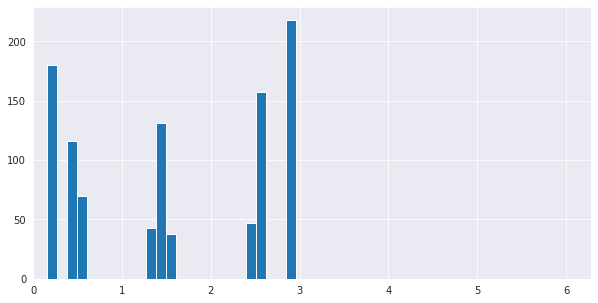

<Figure size 432x288 with 0 Axes>

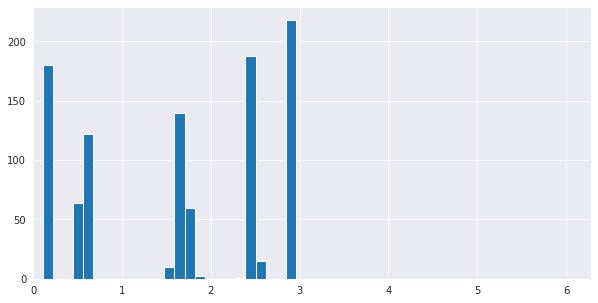

<Figure size 432x288 with 0 Axes>

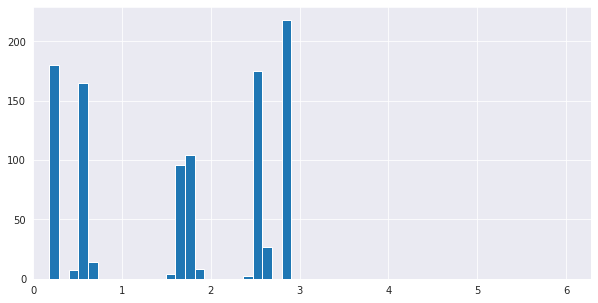

<Figure size 432x288 with 0 Axes>

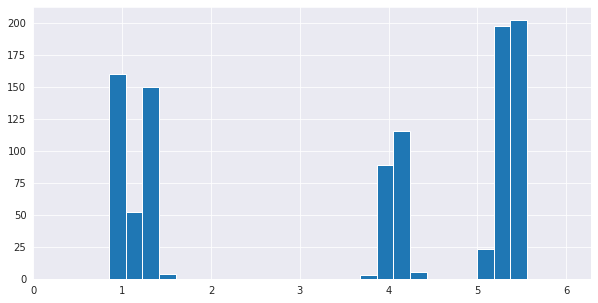

shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape beta torch.Size([1000, 4])
shape exp_torch torch.Size([1000, 5])
shape log_sum_exp torch.Size([1000])
Training loss at step 1: 13.3227
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape beta torch.Size([1000, 4])
shape exp_torch torch.Size([1000, 5])
shape log_sum_exp torch.Size([1000])
Training loss at step 2: 13.0613
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape beta torch.Size([1000, 4])
shape exp_torch torch.Size([1000, 5])
shape log_sum_exp torch.Size([1000])
Training loss at step 3: 13.1428
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
s

<Figure size 432x288 with 0 Axes>

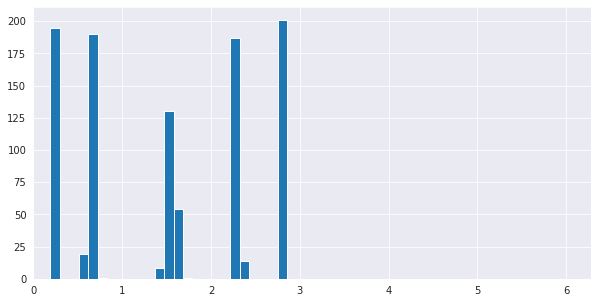

<Figure size 432x288 with 0 Axes>

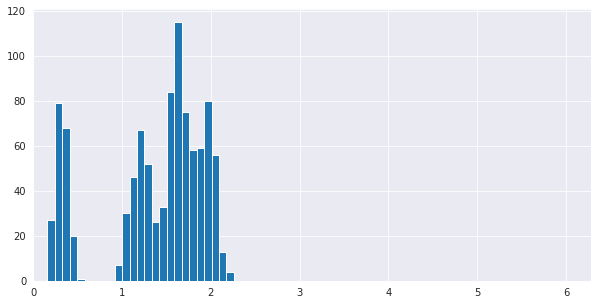

<Figure size 432x288 with 0 Axes>

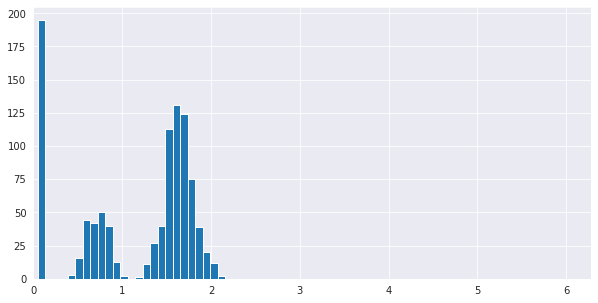

<Figure size 432x288 with 0 Axes>

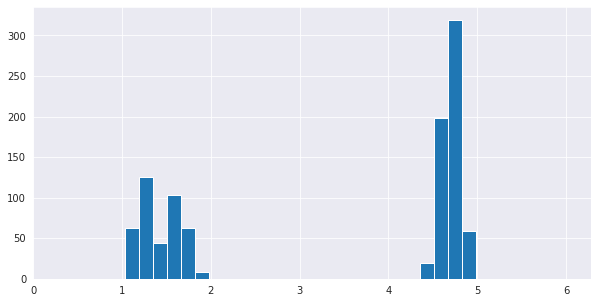

shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape beta torch.Size([1000, 4])
shape exp_torch torch.Size([1000, 5])
shape log_sum_exp torch.Size([1000])
Training loss at step 26: 7.8521
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape beta torch.Size([1000, 4])
shape exp_torch torch.Size([1000, 5])
shape log_sum_exp torch.Size([1000])
Training loss at step 27: 7.7989
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape beta torch.Size([1000, 4])
shape exp_torch torch.Size([1000, 5])
shape log_sum_exp torch.Size([1000])
Training loss at step 28: 7.6456
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
s

<Figure size 432x288 with 0 Axes>

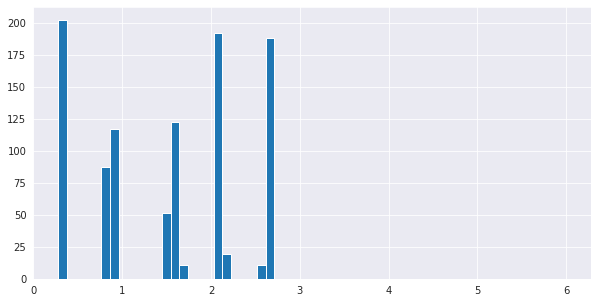

<Figure size 432x288 with 0 Axes>

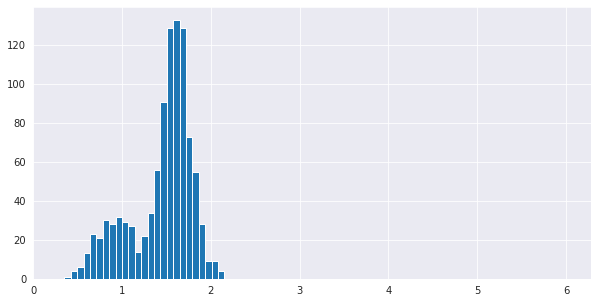

<Figure size 432x288 with 0 Axes>

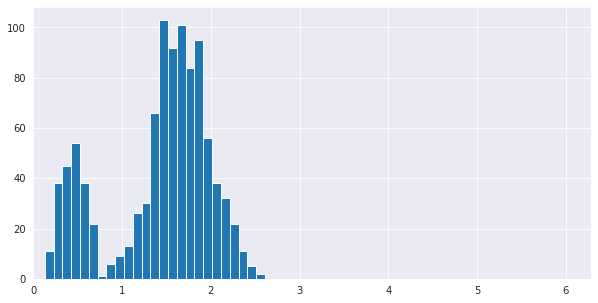

<Figure size 432x288 with 0 Axes>

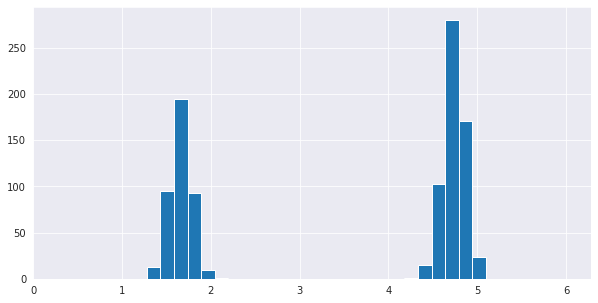

shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape beta torch.Size([1000, 4])
shape exp_torch torch.Size([1000, 5])
shape log_sum_exp torch.Size([1000])
Training loss at step 51: 4.7390
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape beta torch.Size([1000, 4])
shape exp_torch torch.Size([1000, 5])
shape log_sum_exp torch.Size([1000])
Training loss at step 52: 4.6023
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape beta torch.Size([1000, 4])
shape exp_torch torch.Size([1000, 5])
shape log_sum_exp torch.Size([1000])
Training loss at step 53: 4.6381
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
s

<Figure size 432x288 with 0 Axes>

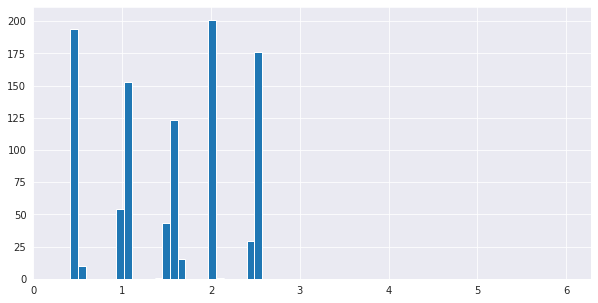

<Figure size 432x288 with 0 Axes>

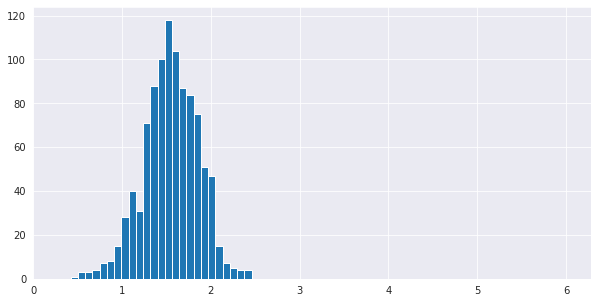

<Figure size 432x288 with 0 Axes>

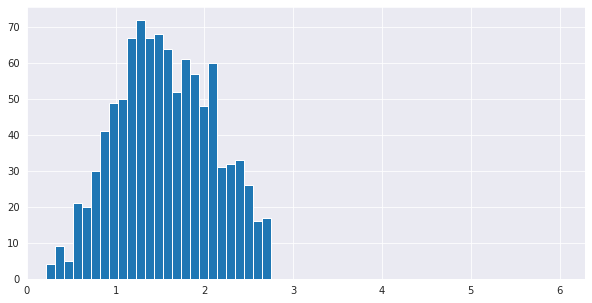

<Figure size 432x288 with 0 Axes>

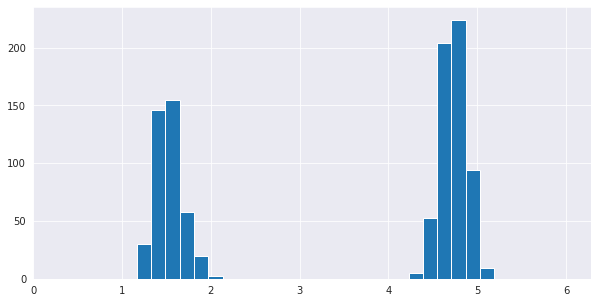

shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape beta torch.Size([1000, 4])
shape exp_torch torch.Size([1000, 5])
shape log_sum_exp torch.Size([1000])
Training loss at step 76: 3.6007
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape beta torch.Size([1000, 4])
shape exp_torch torch.Size([1000, 5])
shape log_sum_exp torch.Size([1000])
Training loss at step 77: 3.5416
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape beta torch.Size([1000, 4])
shape exp_torch torch.Size([1000, 5])
shape log_sum_exp torch.Size([1000])
Training loss at step 78: 3.6715
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
s

<Figure size 432x288 with 0 Axes>

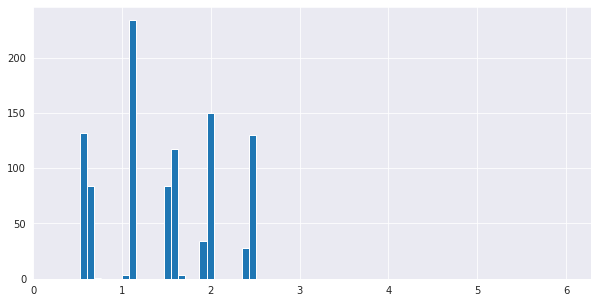

<Figure size 432x288 with 0 Axes>

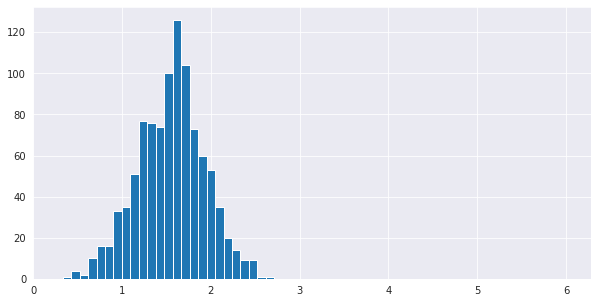

<Figure size 432x288 with 0 Axes>

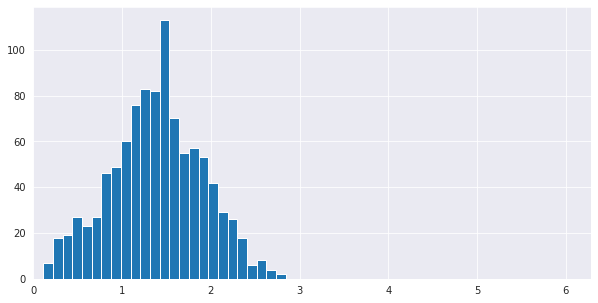

<Figure size 432x288 with 0 Axes>

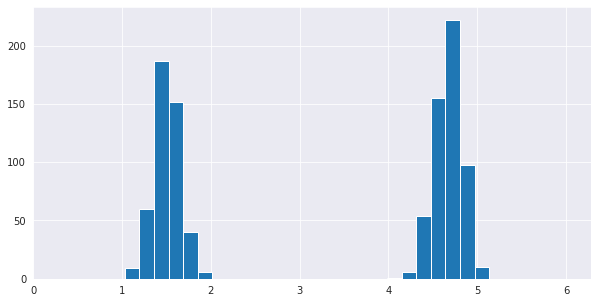

shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape beta torch.Size([1000, 4])
shape exp_torch torch.Size([1000, 5])
shape log_sum_exp torch.Size([1000])
Training loss at step 101: 3.2365
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape beta torch.Size([1000, 4])
shape exp_torch torch.Size([1000, 5])
shape log_sum_exp torch.Size([1000])
Training loss at step 102: 3.1576
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape beta torch.Size([1000, 4])
shape exp_torch torch.Size([1000, 5])
shape log_sum_exp torch.Size([1000])
Training loss at step 103: 3.1599
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1]

In [ ]:
torch.autograd.set_detect_anomaly(False)
flow, loss = train_model(flow, **params)
flow.eval()

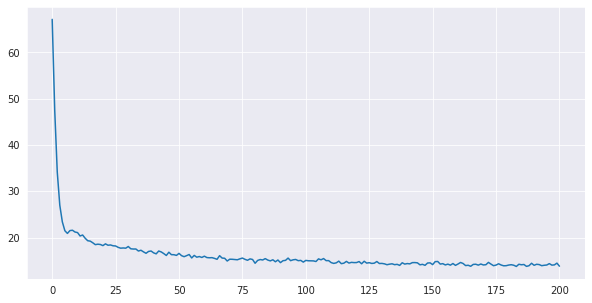

In [479]:
plt.figure(figsize=(10,5))
plt.plot(range(len(loss)), loss)
plt.show()

In [432]:
n_samples = 10_000# 50_000
n_samples_plot = 1000
samples = sample_beta (flow, sample_size=n_samples//20, n_iter=20, device=device)
samples_reshaped = samples.reshape(-1, flow_dim)

100%|██████████| 20/20 [00:36<00:00,  1.80s/it]


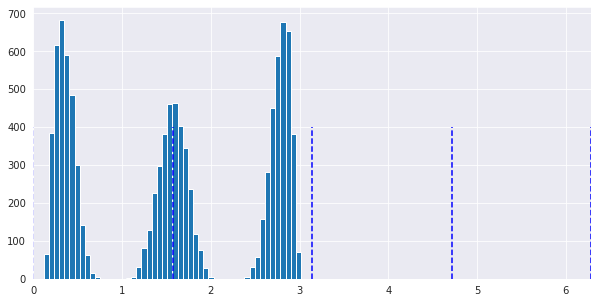

<Figure size 432x288 with 0 Axes>

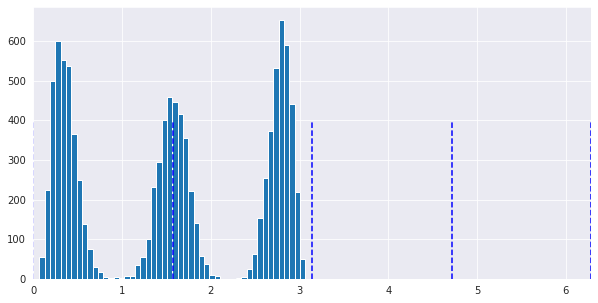

<Figure size 432x288 with 0 Axes>

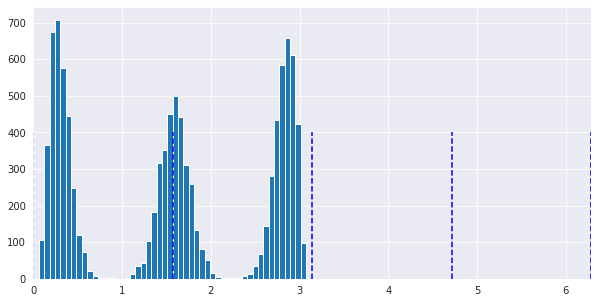

<Figure size 432x288 with 0 Axes>

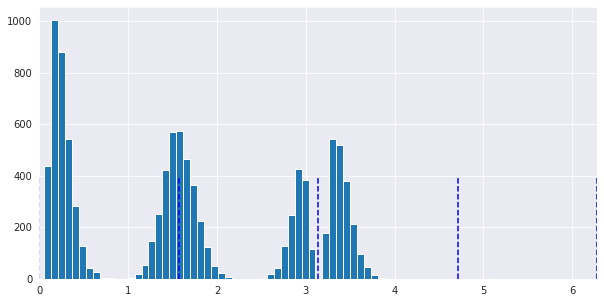

<Figure size 432x288 with 0 Axes>

In [433]:
samples_spherical = cartesian_to_spherical_torch(torch.tensor(samples)).numpy()
for i in range(1, samples_spherical.shape[1]):
    plt.figure(figsize=(10,5))
    #n, bins, patches = plt.hist(samples_spherical[:,i], bins=50)
    plt.hist(samples_spherical[:,i], bins=50)
    plt.vlines([0, np.pi * 0.5, np.pi, np.pi*1.5, 2 * np.pi], ymin=0, ymax=400, linestyles='dashed', colors='b')
    # plt.savefig(f"{dir_name}samples_p{q}_theta_flow.pdf", dpi=100)
    plt.xlim(0, 2*np.pi)
    plt.show()
    plt.clf()

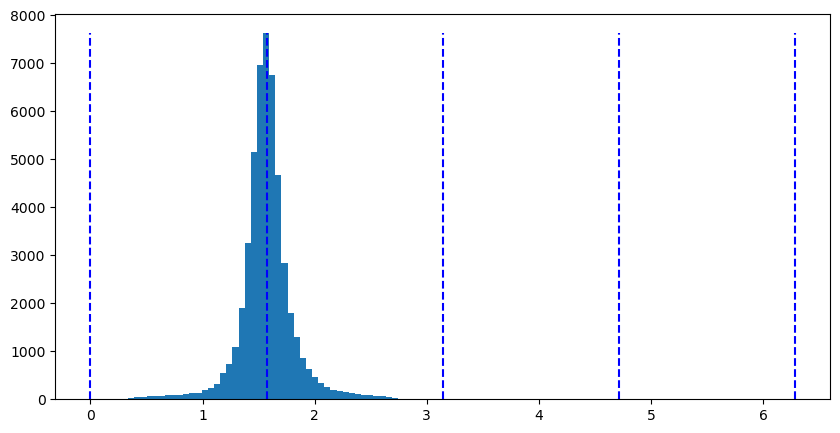

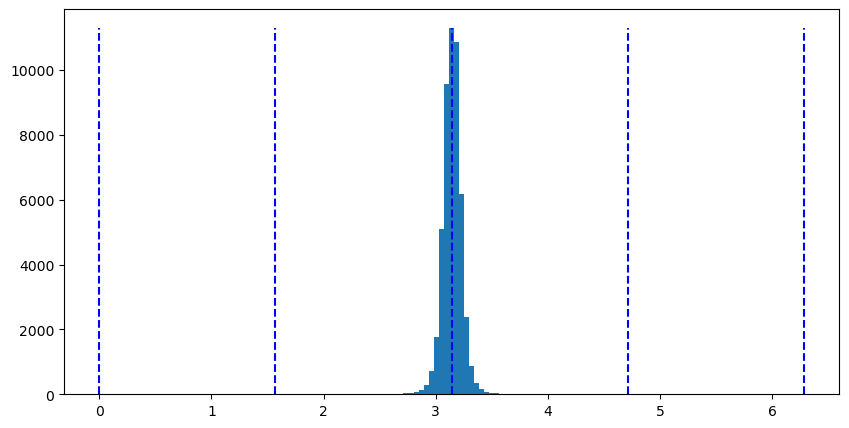

In [21]:
samples_spherical = cartesian_to_spherical_torch(torch.tensor(samples)).numpy()
for i in range(1, samples_spherical.shape[1]):
    plt.figure(figsize=(10,5))
    n, bins, patches = plt.hist(samples_spherical[:,i], bins=50)
    plt.vlines([0, np.pi * 0.5, np.pi, np.pi*1.5, 2 * np.pi], ymin=0, ymax=max(n), linestyles='dashed', colors='b')
    # plt.savefig(f"{dir_name}samples_p{q}_theta_flow.pdf", dpi=100)
    plt.show()

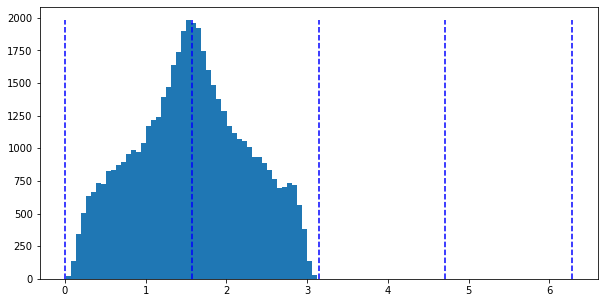

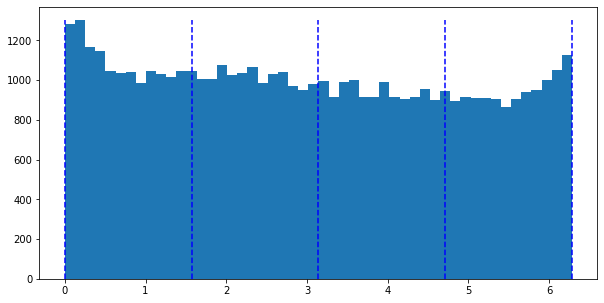

In [364]:
# fig = plt.figure(figsize=(7,7))
# ax = fig.add_subplot(projection='3d')
# ax.scatter(samples_[:n_samples_plot,0], samples_[:n_samples_plot,1], samples_[:n_samples_plot,2], marker='.', alpha=0.5)
# ax_min, ax_max = -1.1, 1.1
# ax.set_xlim3d(ax_min, ax_max)
# ax.set_ylim3d(ax_min, ax_max)
# ax.set_zlim3d(ax_min, ax_max)
# #plt.savefig(f"{dir_name}samples_p{q}_flow.pdf", dpi=100)
# plt.show()

samples_spherical = cartesian_to_spherical_torch(torch.tensor(samples)).numpy()
for i in range(1, samples_spherical.shape[1]):
    plt.figure(figsize=(10,5))
    n, bins, patches = plt.hist(samples_spherical[:,i], bins=50)
    plt.vlines([0, np.pi * 0.5, np.pi, np.pi*1.5, 2 * np.pi], ymin=0, ymax=max(n), linestyles='dashed', colors='b')
    # plt.savefig(f"{dir_name}samples_p{q}_theta_flow.pdf", dpi=100)
    plt.show()

In [357]:
from rpy2.robjects.packages import importr
rpgnorm = importr('pgnorm')
%R -i q -i flow_dim -i n_samples -o samples samples <- rpgnorm(n_samples * flow_dim, q)
samples = np.array(samples).reshape(-1,flow_dim)
samples_norm = lp_norm(samples, q)

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


torch.Size([50000])
torch.Size([50000, 2])
torch.Size([50000])


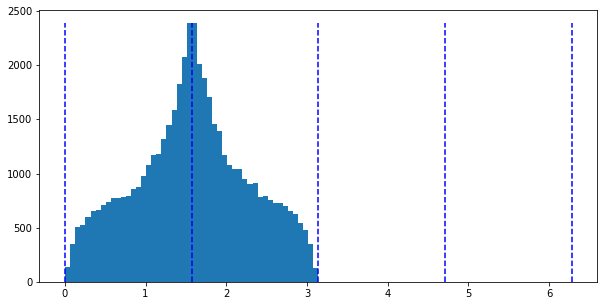

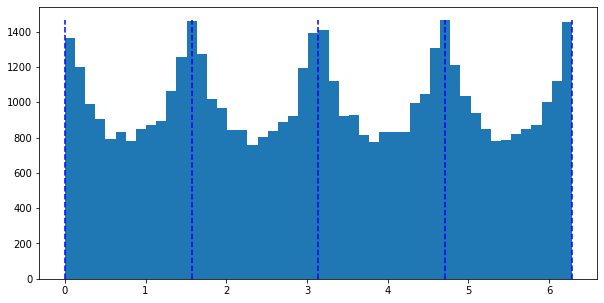

In [358]:
# fig = plt.figure(figsize=(7,7))
# ax = fig.add_subplot(projection='3d')
# ax.scatter(samples_norm[:n_samples_plot,0], samples_norm[:n_samples_plot,1], samples_norm[:n_samples_plot,2], marker='.', alpha=0.5)
# ax_min, ax_max = -1.1, 1.1
# ax.set_xlim3d(ax_min,ax_max)
# ax.set_ylim3d(ax_min,ax_max)
# ax.set_zlim3d(ax_min,ax_max)
# #ax = plt.gca()
# #ax.set_aspect('equal', adjustable='box')
# #plt.savefig(f"{dir_name}samples_p{q}_gt.pdf", dpi=100)
# plt.show()


samples_spherical = cartesian_to_spherical_torch(torch.from_numpy(samples_norm)).numpy()
for i in range(1, samples_spherical.shape[1]):
    plt.figure(figsize=(10,5))
    n, bins, patches = plt.hist(samples_spherical[:,i], bins=50)
    plt.vlines([0, np.pi * 0.5, np.pi, np.pi*1.5, 2 * np.pi], ymin=0, ymax=max(n), linestyles='dashed', colors='b')
    # plt.savefig(f"{dir_name}samples_p{q}_theta_gt.pdf", dpi=100)
    plt.show()

In [135]:
sol_2 = n_sphere.convert_rectangular(n_sphere.convert_spherical(samples_norm))

100%|██████████| 20/20 [00:53<00:00,  2.67s/it]


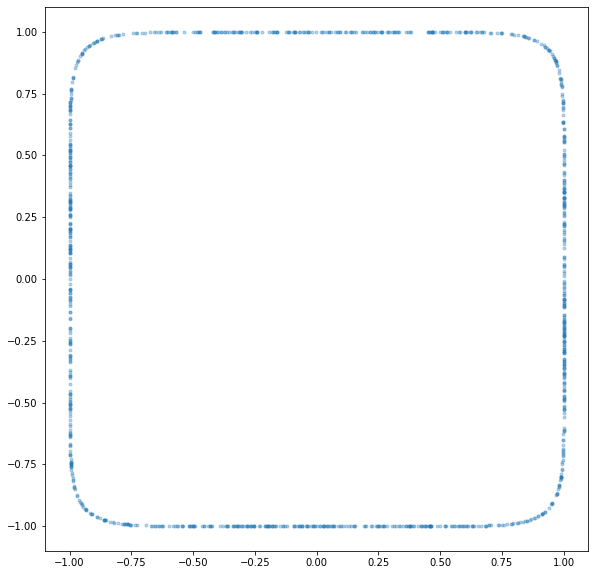

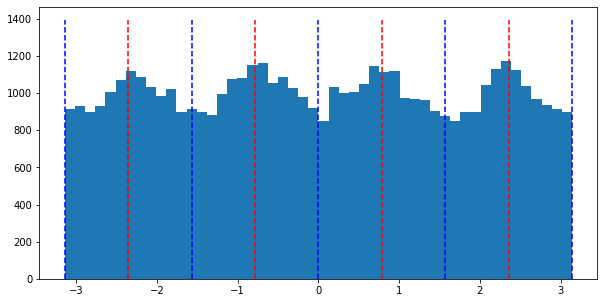

In [446]:
n_samples = 50_000
n_samples_plot = 1000
samples = sample_beta (flow, sample_size=n_samples//20, n_iter=20, device=device)
samples = samples.reshape(-1,2)
plt.figure(figsize=(10,10))
plt.scatter(samples[:n_samples_plot,0], samples[:n_samples_plot,1], marker='.', alpha=0.3)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.savefig(f"{dir_name}samples_p{q}_flow.pdf", dpi=100)
plt.show()

theta_ = theta_given_x_y(samples)
plt.figure(figsize=(10,5))
plt.hist(theta_, bins=50)
plt.vlines([-np.pi * 0.75, -np.pi * 0.25, np.pi * 0.25, np.pi * 0.75], ymin=0, ymax=max(n), linestyles='dashed', colors='r')
plt.vlines([-np.pi, -np.pi * 0.5, 0, np.pi * 0.5, np.pi], ymin=0, ymax=max(n), linestyles='dashed', colors='b')
plt.savefig(f"{dir_name}samples_p{q}_theta_flow.pdf", dpi=100)
plt.show()

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


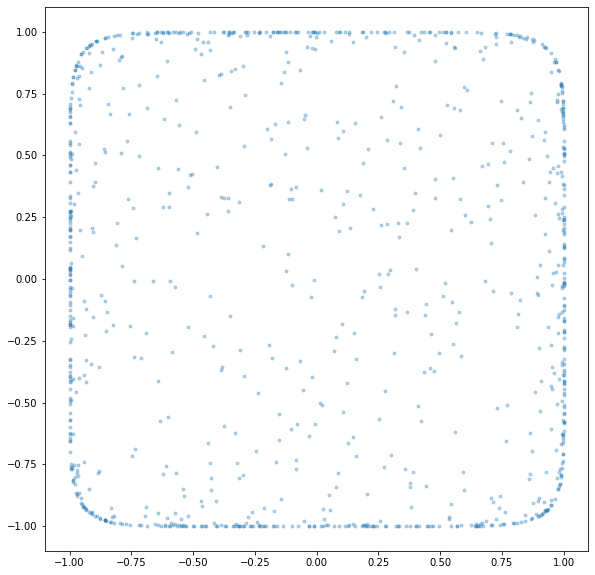

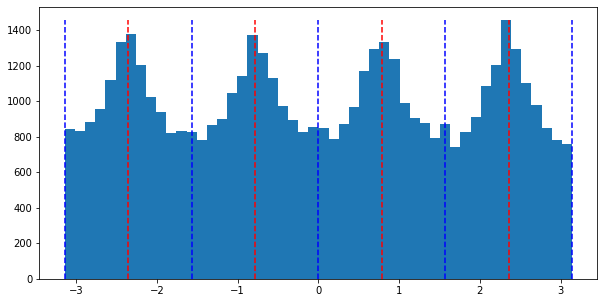

In [485]:
from rpy2.robjects.packages import importr
flow_dim = 3
rpgnorm = importr('pgnorm')
%R -i q -i flow_dim -i n_samples -o samples samples <- rpgnorm(n_samples * flow_dim, q)
samples = np.array(samples).reshape(-1,flow_dim)
samples_norm = lp_norm(samples, q)
plt.figure(figsize=(10,10))
plt.scatter(samples_norm[:n_samples_plot,0], samples_norm[:n_samples_plot,1], marker='.', alpha=0.3)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.savefig(f"{dir_name}samples_p{q}_gt.pdf", dpi=100)
plt.show()

plt.figure(figsize=(10,5))
theta_ = theta_given_x_y(samples_norm)
n, bins, patches = plt.hist(theta_, bins=50)
plt.vlines([-np.pi * 0.75, -np.pi * 0.25, np.pi * 0.25, np.pi * 0.75], ymin=0, ymax=max(n), linestyles='dashed', colors='r')
plt.vlines([-np.pi, -np.pi * 0.5, 0, np.pi * 0.5, np.pi], ymin=0, ymax=max(n), linestyles='dashed', colors='b')
plt.savefig(f"{dir_name}samples_p{q}_theta_gt.pdf", dpi=100)
plt.show()